In [8]:
import sys
import time
sys.path.append('../python')
from plot_info import *
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D
import keras

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import os.path

input_size=40
train_size=128
validation_size=200
data_path='/run/media/klye/TOSHIBA EXT/kh_1.nc'
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

['/job:localhost/replica:0/task:0/device:GPU:0']
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 493656657444370395
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11387830272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10071266601874874851
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [9]:

class AreaFunctional(object):
    def __init__(self, integrate_coordinate = [0.55,0.35], integrate_width=[0.25,0.25],variable='rho'):
        self.integrate_coordinate = integrate_coordinate
        self.integrate_width = integrate_width
        
        self.variable = variable
        self.first = 10
        
    def title(self):
        return 'integrated area: $[%f,%f]\\times [%f,%f]$'% (self.integrate_coordinate[0],
                                                            self.integrate_coordinate[1],
                                                            self.integrate_width[0],
                                                            self.integrate_width[1])
    def area(self, I):
        
        return 1*(I[1][0]-I[0][0])*(I[1][1]-I[0][1])
    def __call__(self, rho):
        N = rho.shape[0]
        
        integrate_area = [[int(N*self.integrate_coordinate[0]), int(N*self.integrate_coordinate[1])],
                          [int(N*self.integrate_coordinate[0]+N*self.integrate_width[0]), 
                           int(N*self.integrate_coordinate[1]+N*self.integrate_width[1])]]
        
        g = sum(rho[integrate_area[0][0]:integrate_area[1][0], integrate_area[0][1]:integrate_area[1][1]])/self.area(integrate_area)
        
      
        return g
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.integrate_coordinate[0],self.integrate_coordinate[1]),
                                     self.integrate_width[0],
                                     self.integrate_width[1],
                                     linewidth=1,edgecolor='r',facecolor='none')
        
        axes = plt.gca()
        axes.add_patch(rect)
        plt.show()
        
        
class SinglePointFunctional(object):
    def __init__(self, coordinate = [0.55,0.35], variable='rho'):
        self.coordinate = coordinate
        
        self.variable = variable
        self.first = 10
        
    def title(self):
        return 'specific point  $(%f,%f)$'% (self.coordinate[0], self.coordinate[1])

    def __call__(self, rho):
        N = rho.shape[0]
        
        x = int(N*self.coordinate[0])
        y = int(N*self.coordinate[1])
        
        return rho[x,y]
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.coordinate[0],self.coordinate[1]),
                                     0.05,
                                     0.05,
                                     linewidth=1,edgecolor='r',facecolor='r')
        
        axes = plt.gca()
        axes.add_patch(rect)
        plt.show()
    
    
class Identity(object):
    def __init__(self, variable='rho'):
        
        self.variable = variable
        
    def title(self):
        return 'whole field (id)'

    def __call__(self, rho):
        return rho[::8,::8]
    
    def plot(self, d):
        d = self(d)
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
       
        plt.show()
    

In [10]:
def get_samples(data_path, functional,max_samples=1024):
    samples = []
    
    with netCDF4.Dataset(data_path) as f:
        for k in f.variables.keys():
            if functional.variable in k:
                sys.stdout.write("%d\r" % len(samples))
                sys.stdout.flush()
                samples.append(functional(f.variables[k][:,:,0]))
                
                if len(samples) >= max_samples:
                    break
                
               
    print()
    return array(samples,dtype=float64)
def draw_functional(data_path, functional):
    with netCDF4.Dataset(data_path) as f:
        d = f.variables['sample_10_%s' % functional.variable][:,:,0]
        functional.plot(d)
        

                

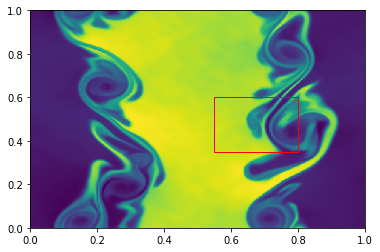

In [11]:
draw_functional(data_path, AreaFunctional())

In [12]:
def get_network_from_functional(data_path, functional, parameters, epochs=500000,max_samples=1024):
    start_reading_samples = time.time()
    samples = get_samples(data_path, functional,max_samples)
    end_reading_samples = time.time()
    print("Reading all samples took {} seconds".format(end_reading_samples-start_reading_samples))
    return get_network(parameters, samples, train_size=train_size, validation_size=validation_size, epochs=epochs,
                      title=functional.title())
def get_network_from_functional_qmc(data_path, functional,epochs=500000, max_samples=1024):
    parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
    parameters = loadtxt(parameter_path)[:max_samples,:]
    
    return get_network_from_functional(data_path, functional, parameters, epochs,max_samples=max_samples)
def get_network(parameters, data, *, train_size, validation_size, epochs=500000, title=''):
    import numpy as np
    
    data = data.reshape(data.shape[0], data.shape[1]*data.shape[2])
    print(data.dtype)
    print(type(data))
    print(data.shape)
    if np.isnan(data).any():
        print("We have a nan!")
    if np.isinf(data).any():
        print("we have an inf!")
    print(data.shape[1])
    input_size = parameters.shape[1]
    model = Sequential([
        Dense(data.shape[1], input_shape=(input_size,)),
        Activation('relu'),
        Dense(data.shape[1]),
        Activation('relu'),
        Dense(2*data.shape[1]),
        Activation('relu'),
        Dense(2*data.shape[1]),
        Activation('relu'),
        Dense(data.shape[1]),
        Activation('relu'),
        Dense(data.shape[1]),
        Activation('relu'),
        Dense(data.shape[1])
    ])
    model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
                  loss='mean_squared_error')
    x_train = parameters[:train_size,:]
  
    y_train=data[:train_size]
    
    
    x_val = parameters[train_size:validation_size+train_size,:]
    y_val=data[train_size:train_size+validation_size,:]
   
    epochs_r=range(1, epochs)
   
    start_training_time = time.time()
  
    hist = model.fit(x_train,
        
                     y_train,
                     batch_size=train_size,
                     #steps_per_epoch=1,
                     epochs=epochs,shuffle=True, 
                     validation_data=(x_val, y_val),
                     #validation_split=validation_size/(validation_size+train_size),
                    #validation_data= ([x_val[k,:] for k in range(x_val.shape[0])], [y_val[k,:] for k in range(x_val.shape[0])]),
                                verbose=0)
    end_training_time = time.time()
    print("Training took {} seconds".format(end_training_time-start_training_time))
    plt.loglog(hist.history['loss'])
    plt.title("Training loss\n%s\n(epochs=%d)" % (title, epochs))
    showAndSave("training_loss")
    
    plt.loglog(hist.history['val_loss'])
    plt.title("Validation loss\n%s\n(epochs=%d)" % (title, epochs))
    showAndSave("training_loss")

   
    print(model.summary())
    print("Number of parameters: %d"% model.count_params())
    
    return  model, data.reshape(data.shape[0], int(sqrt(data.shape[1])), int(sqrt(data.shape[1]))), parameters

In [13]:
def mean_var(d):
    N = d.shape[1]
    mean = zeros((N,N))
    var = zeros((N,N))
    
    print(mean.dtype)
    print(var.dtype)
    print(d.dtype)
    M= d.shape[0]
    for k in range(M):
        mean += d[k,:,:]
        var += d[k,:,:]**2
    mean /= M
    var /= M
    var -= mean**2
    
    return mean, var

def get_network_interpolate_qmc(data_path, functional, epochs=500000,max_samples=1024):
    title='whole field'
    draw_functional(data_path, functional)
    network, data, parameters = get_network_from_functional_qmc(data_path, functional, epochs,max_samples=max_samples)
   
   
    points = [[0.5,0.7], [0.7,0.5],[0.5,0.8],[0.8,0.5]]
    N = data.shape[1]
    
    mean_qmc, var_qmc =mean_var(data)
    mean_few_qmc, var_few_qmc = mean_var(data[:train_size,:,:])
    mean_ml, var_ml = mean_var(network.predict(parameters).reshape(data.shape))
    
    x,y=mgrid[0:1:N*1j,0:1:N*1j]
    
    plt.pcolormesh(x,y,mean_qmc)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("mean QMC with %d samples" % data.shape[0])
    showAndSave("mean_qmc_%d" % (data.shape[0]))
    
    
    plt.pcolormesh(x,y,mean_few_qmc)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("mean QMC with %d samples" % train_size)
    showAndSave("mean_qmc_%d" % train_size)
    
    plt.pcolormesh(x,y,mean_ml)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("mean ML with %d samples" % train_size)
    showAndSave("mean_ml_%d" % train_size)
    
    
    
    plt.pcolormesh(x,y,var_qmc)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("variance QMC with %d samples" % data.shape[0])
    showAndSave("var_qmc_%d" % (data.shape[0]))
    
    
    plt.pcolormesh(x,y,var_few_qmc)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("var QMC with %d samples" % train_size)
    showAndSave("var_qmc_%d" % train_size)
    
    plt.pcolormesh(x,y,var_ml)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("var ML with %d samples" % train_size)
    showAndSave("var_ml_%d" % train_size)
    predicted = network.predict(parameters).reshape(data.shape)
    for p in points:
        
        x = int(p[0]*N)
        y = int(p[1]*N)
        plt.hist(data[:,x,y],bins=40,density=True,label='QMC %d samples' % data.shape[0],alpha=0.5)
        plt.title("Comparison QMC and Machine learning\n%s\nepochs=%d\n at $(%f,%f)$"% (title, epochs,p[0],p[1]))
        plt.hist(predicted[:,x,y],bins=40,density=True,label='ML(%d samples)' % train_size,alpha=0.5)
        plt.legend()
        showAndSave('hist_qmc_ml_whole_%d_%d' %(x,y))
        
        
        plt.title("Comparison QMC with %d and QMC with %d samples\n%s\nat $(%f,%f)$" %(data.shape[0], train_size, title,p[0],p[1]))
        plt.hist(data[:,x,y],bins=40,density=True,label='QMC %d samples' % data.shape[0],alpha=0.5)
        plt.hist(data[:train_size,x,y],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
        plt.legend()
        showAndSave('hist_qmc_qmc_whole_%d_%d'%(x,y))
        
        
        from sklearn import linear_model
        reg = linear_model.LinearRegression()
        y_train = data[:train_size,x,y]
        coeffs = reg.fit(parameters[:train_size,:], y_train)
        evaluated_lsq = coeffs.predict(parameters)
        plt.title("Comparison QMC with least squares\n%s\n at $(%f,%f)$" % (title,p[0],p[1]))
        plt.hist(data[:,x,y],bins=40,density=True,label='QMC %d samples'%data.shape[0],alpha=0.5)
        plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
        plt.legend()
        showAndSave('hist_qmc_lsq_whole_%d_%d'%(x,y))
        
    return network, data, parameters

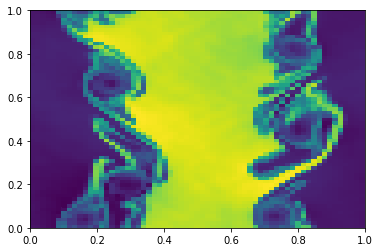

1023
Reading all samples took 161.60353231430054 seconds
float64
<class 'numpy.ndarray'>
(1024, 4096)
4096
Training took 380.39305686950684 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


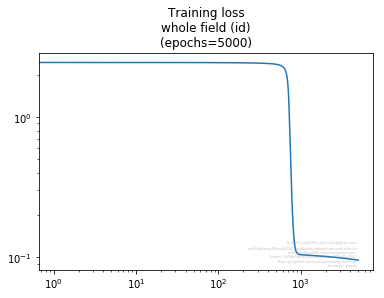

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


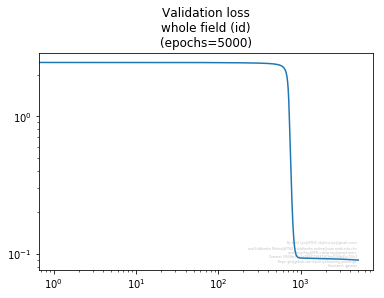

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 4096)              167936    
_________________________________________________________________
activation_7 (Activation)    (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_8 (Activation)    (None, 4096)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 8192)              33562624  
_________________________________________________________________
activation_9 (Activation)    (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 8192)              67117056  
__________

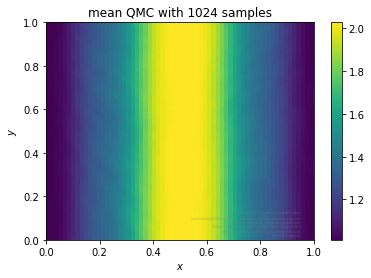

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


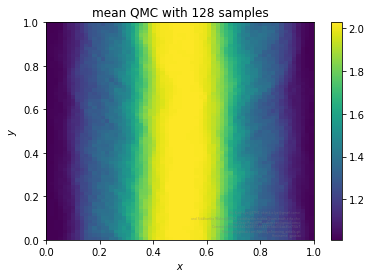

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


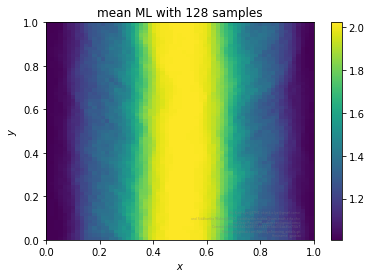

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


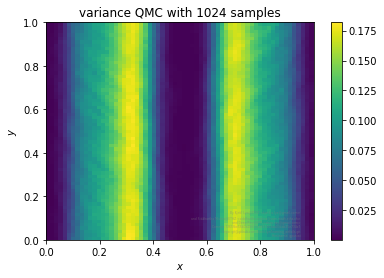

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


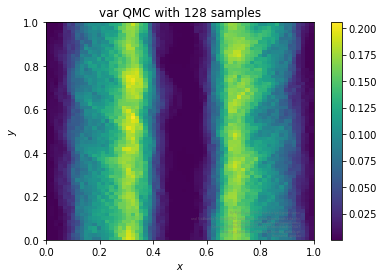

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


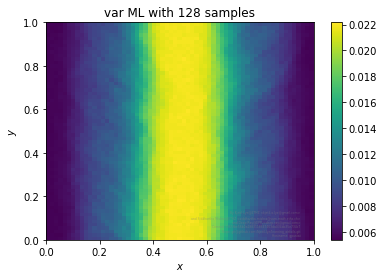

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


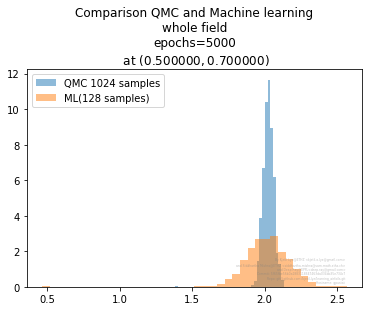

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


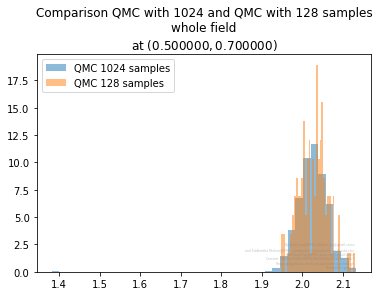

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


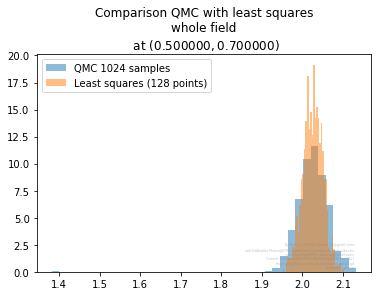

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


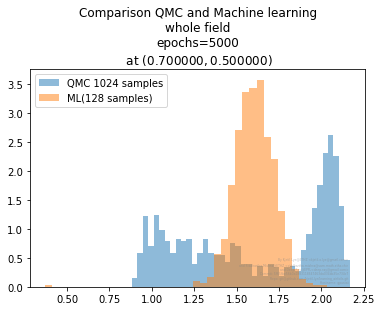

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


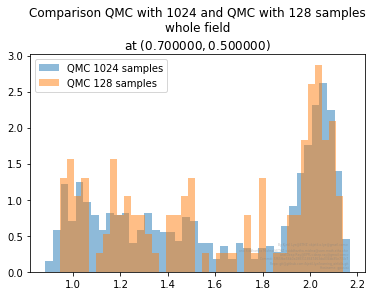

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


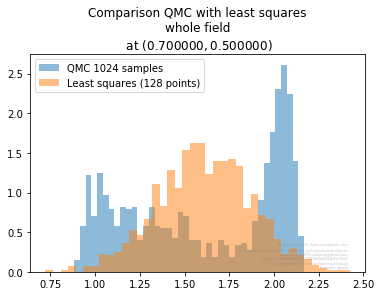

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


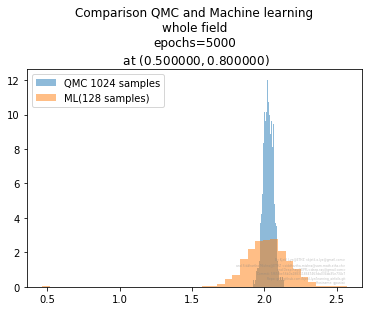

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


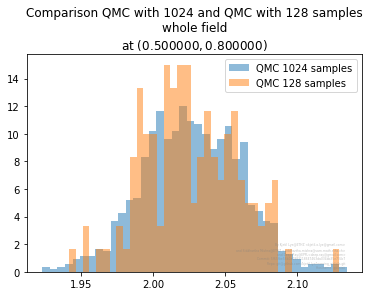

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


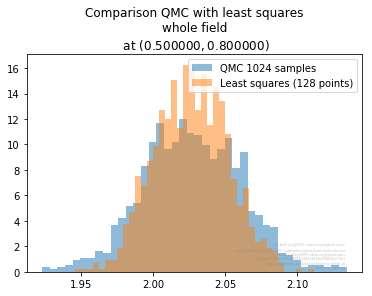

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


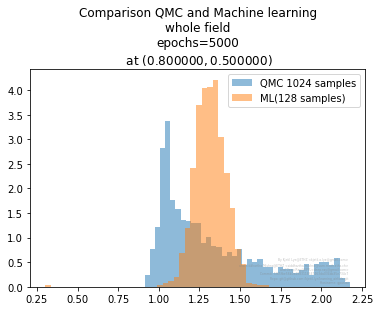

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


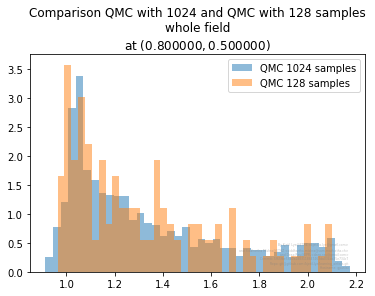

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


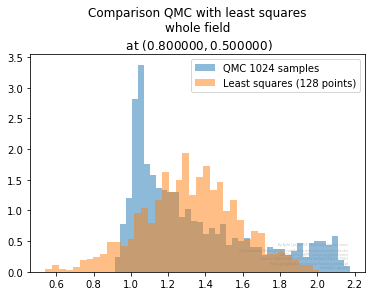

In [16]:
network, data, parameters = get_network_interpolate_qmc(data_path, Identity(), 5000,1024)

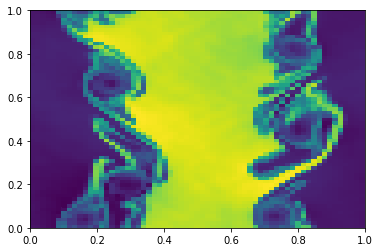

1023
Reading all samples took 4.090542316436768 seconds
float64
<class 'numpy.ndarray'>
(1024, 4096)
4096
Training took 3151.045257091522 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


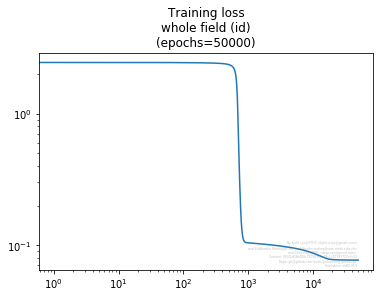

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


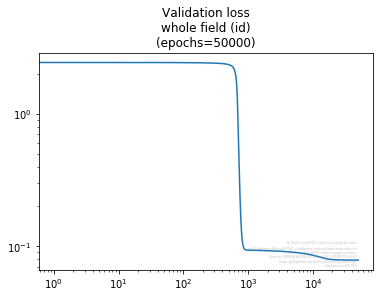

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 4096)              167936    
_________________________________________________________________
activation_25 (Activation)   (None, 4096)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
activation_26 (Activation)   (None, 4096)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 8192)              33562624  
_________________________________________________________________
activation_27 (Activation)   (None, 8192)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 8192)              67117056  
__________

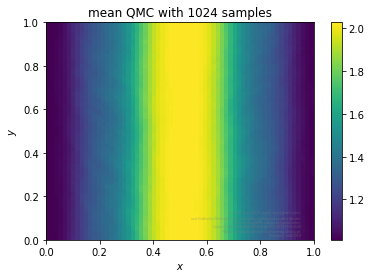

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


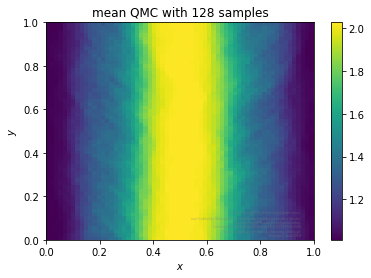

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


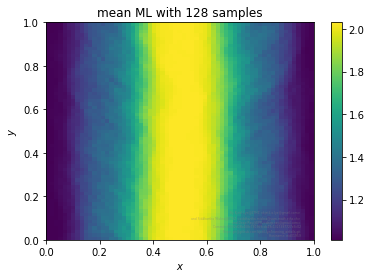

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


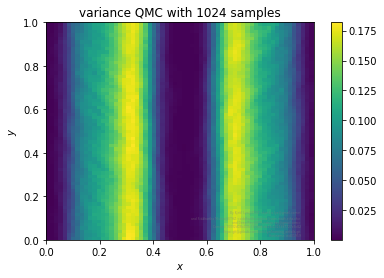

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


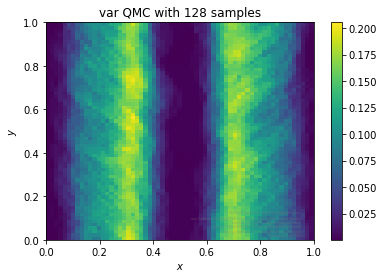

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


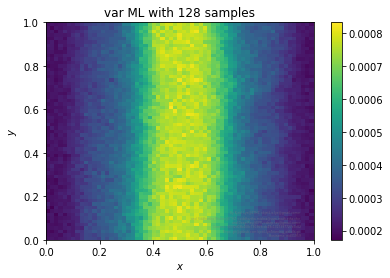

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


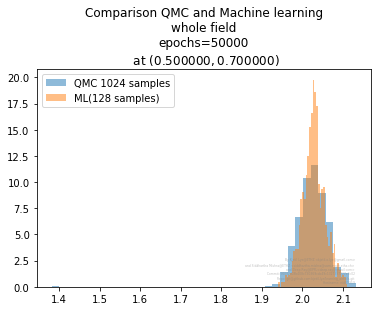

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


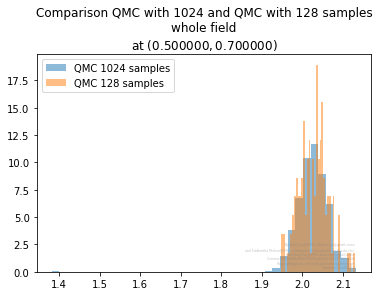

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


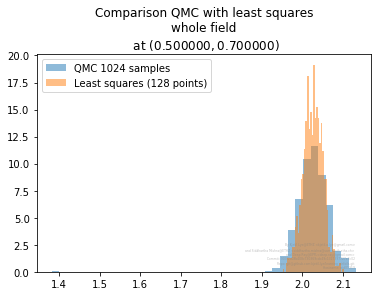

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


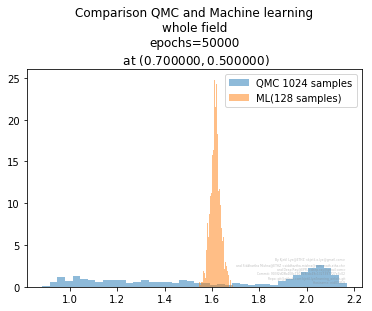

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


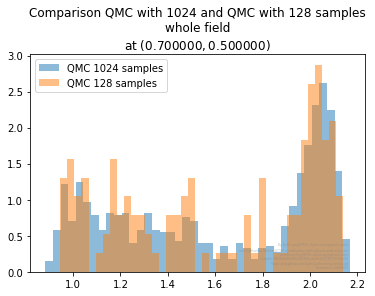

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


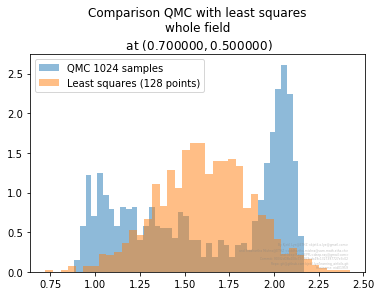

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


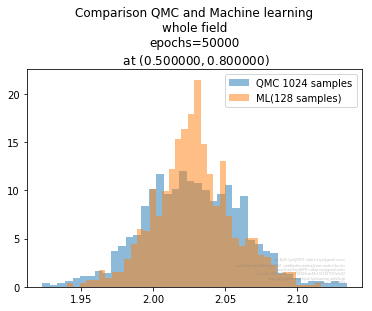

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


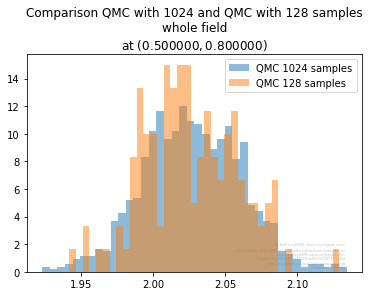

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


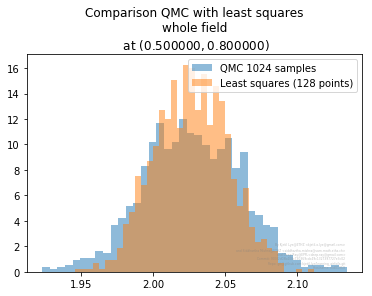

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


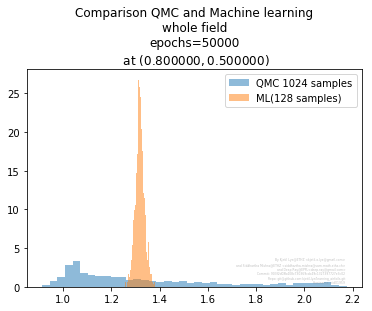

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


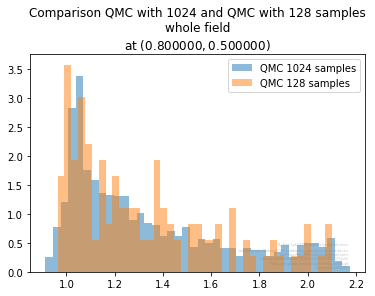

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


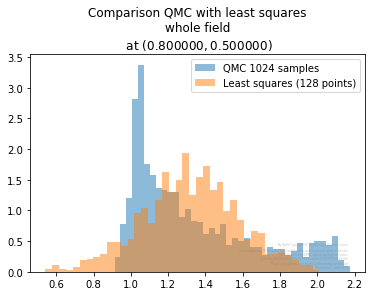

In [14]:
network, data, parameters = get_network_interpolate_qmc(data_path, Identity(), 50000,1024)

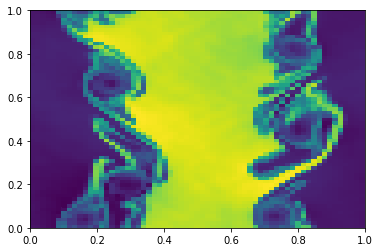

1023
Reading all samples took 4.015460014343262 seconds
float64
<class 'numpy.ndarray'>
(1024, 4096)
4096
Training took 31476.590470314026 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


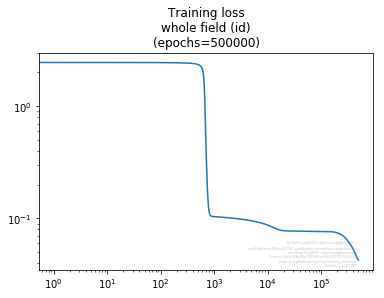

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


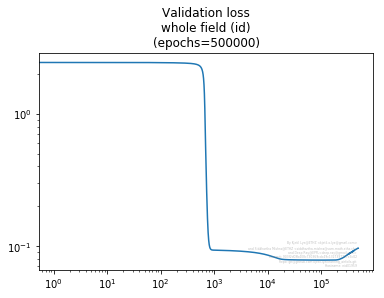

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 4096)              167936    
_________________________________________________________________
activation_31 (Activation)   (None, 4096)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
activation_32 (Activation)   (None, 4096)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 8192)              33562624  
_________________________________________________________________
activation_33 (Activation)   (None, 8192)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 8192)              67117056  
__________

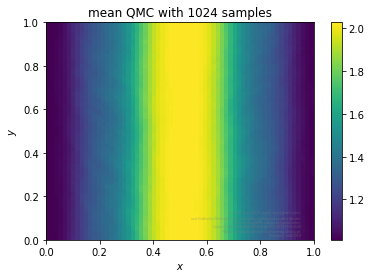

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


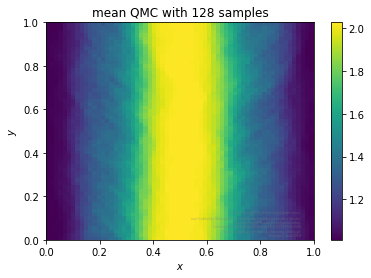

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


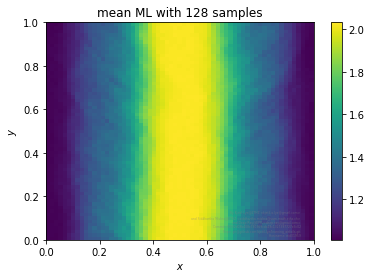

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


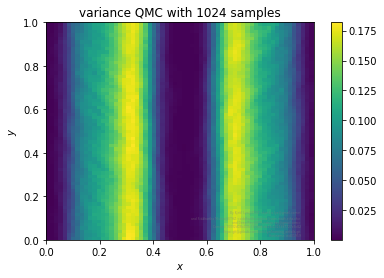

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


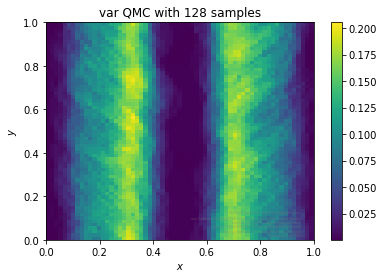

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


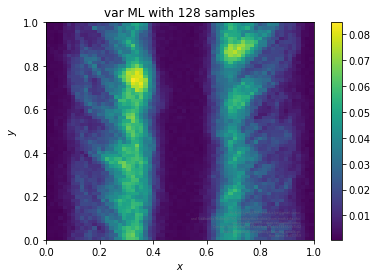

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


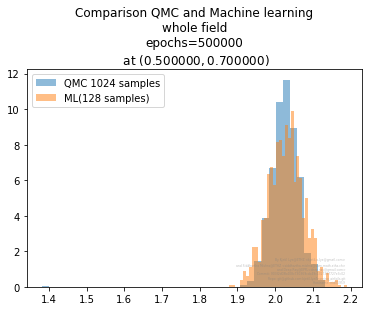

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


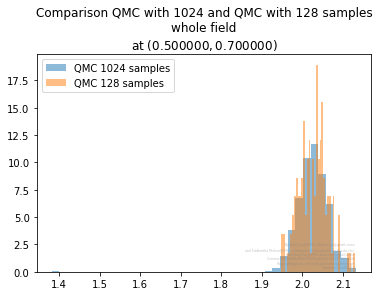

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


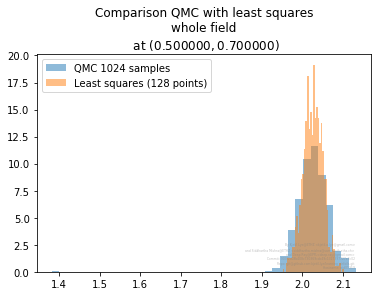

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


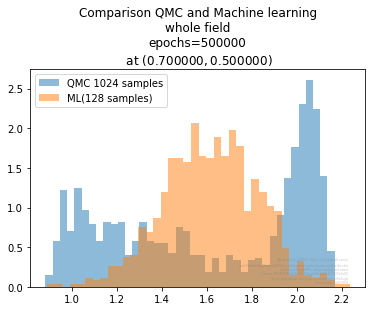

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


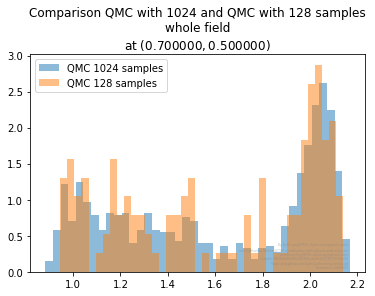

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


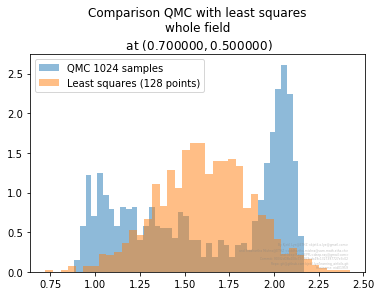

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


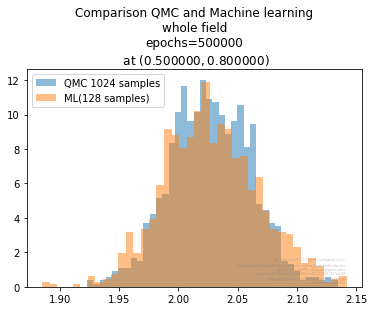

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


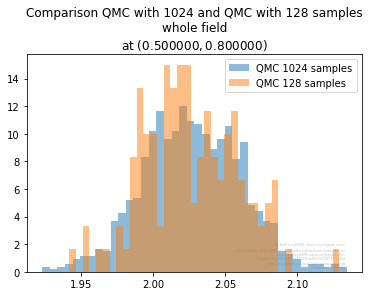

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


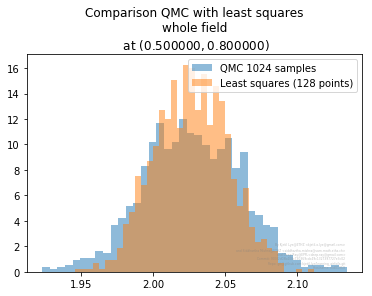

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


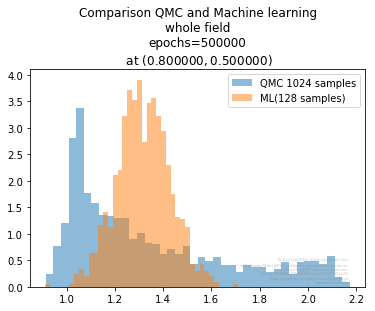

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


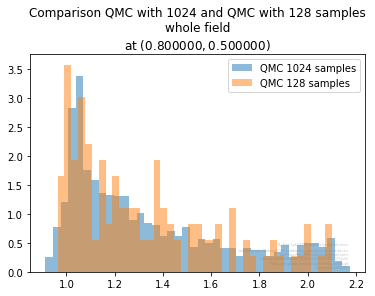

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


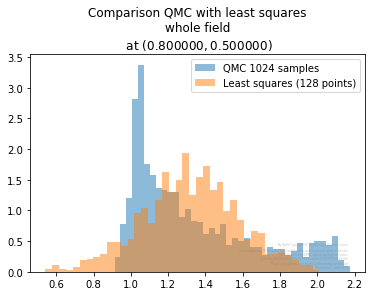

In [15]:
network, data, parameters = get_network_interpolate_qmc(data_path, Identity(), 500000,1024)

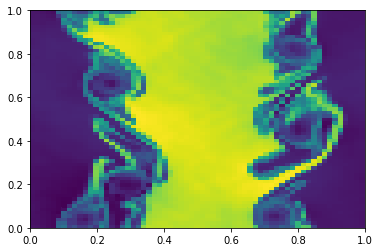

1023
Reading all samples took 3.0561609268188477 seconds
float64
<class 'numpy.ndarray'>
(1024, 4096)
4096
Training took 148042.4101819992 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


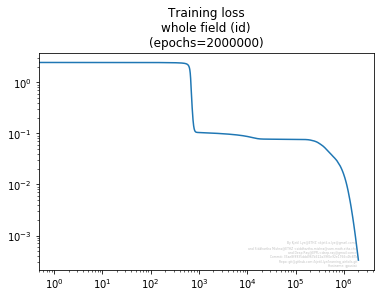

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


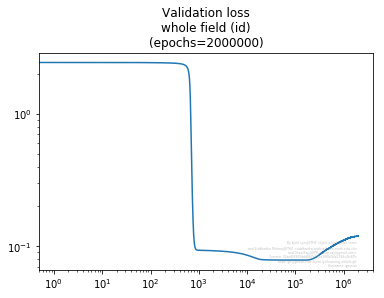

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 4096)              167936    
_________________________________________________________________
activation_19 (Activation)   (None, 4096)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
activation_20 (Activation)   (None, 4096)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 8192)              33562624  
_________________________________________________________________
activation_21 (Activation)   (None, 8192)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 8192)              67117056  
__________

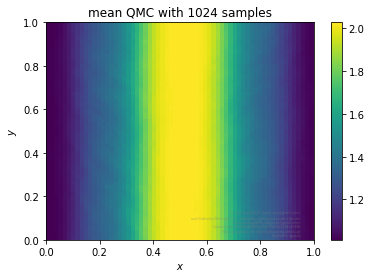

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


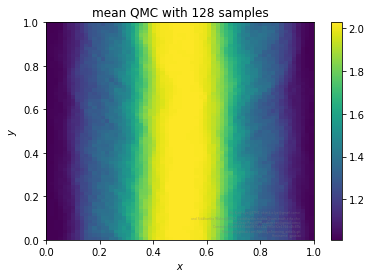

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


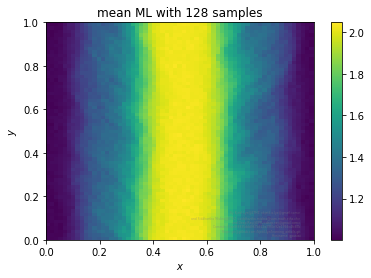

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


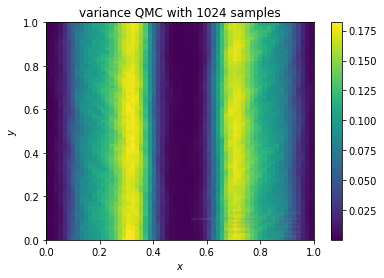

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


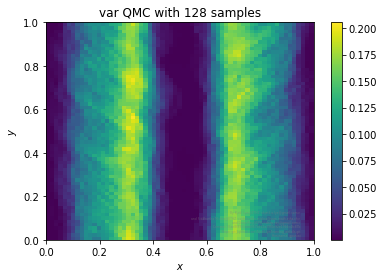

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


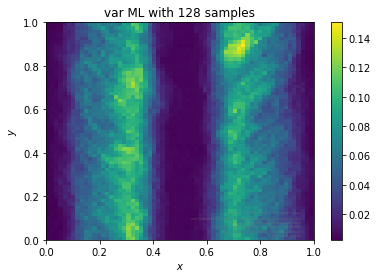

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


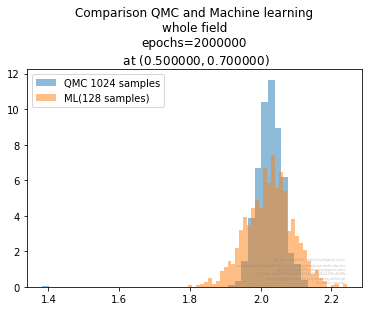

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


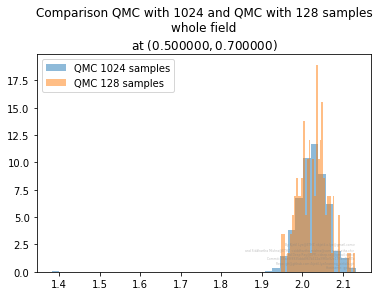

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


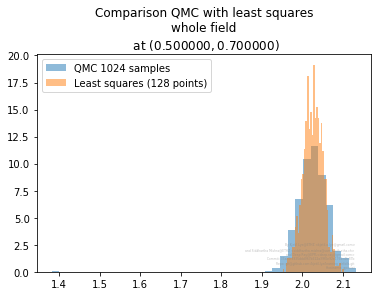

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


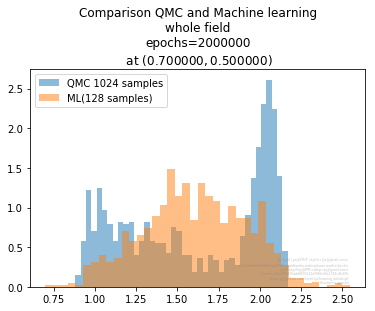

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


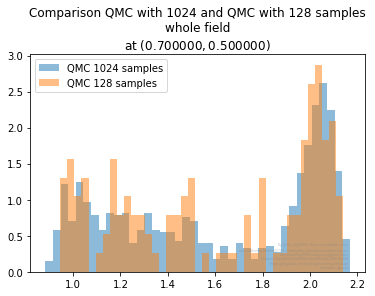

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


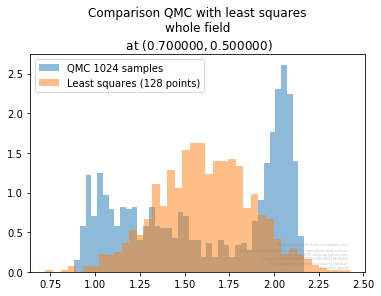

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


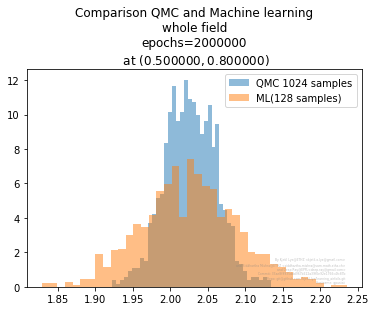

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


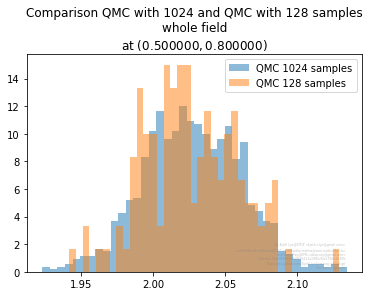

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


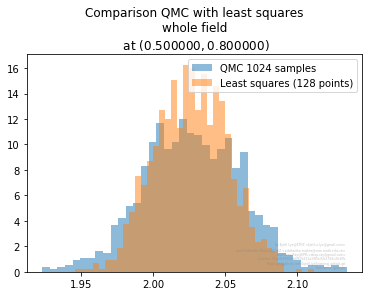

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


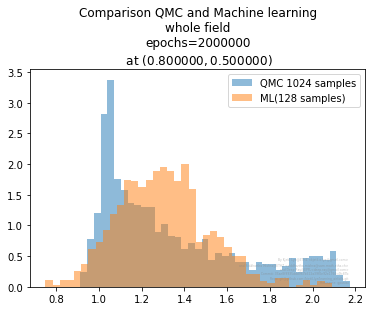

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


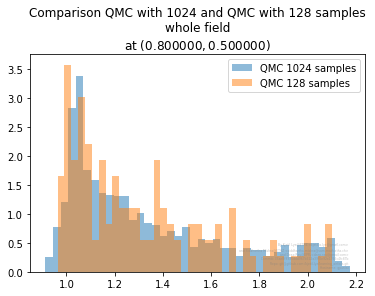

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


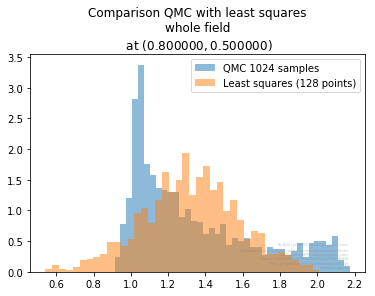

In [18]:
network, data, parameters = get_network_interpolate_qmc(data_path, Identity(), 2000000,1024)

In [ ]:
network, data, parameters = get_network_interpolate_qmc(data_path, Identity(), 4000000,1024)

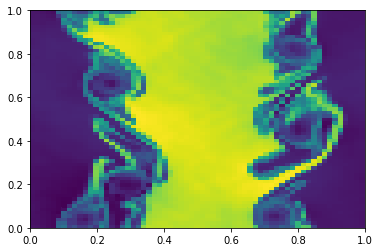

1023
Reading all samples took 2.948444128036499 seconds
float64
<class 'numpy.ndarray'>
(1024, 4096)
4096


ResourceExhaustedError: OOM when allocating tensor with shape[8192,8192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_4/SGD/gradients/dense_32/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, _class=["loc:@training_4/SGD/gradients/dense_32/MatMul_grad/MatMul"], transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_27/Relu, training_4/SGD/gradients/activation_28/Relu_grad/ReluGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [19]:
network, data, parameters = get_network_interpolate_qmc(data_path, Identity(), 8000000,1024)